In [35]:
import os
import numpy as np

import mne
from mne.io import read_raw_edf
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
import tensorflow
from sklearn.metrics import cohen_kappa_score, f1_score, precision_score, recall_score,confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, LSTM, GRU, Bidirectional, Input, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.optimizers import Adam
tensorflow.random.set_seed(42)

## Data
Download PhysioNet EEG Motor Movement/Imagery Dataset from the link https://physionet.org/content/eegmmidb/1.0.0/ saved in path "./data"

## TASKS
task1 --> left vs right hand motor imagery classification <br>
task2 --> left vs right hand motor execution classification <br>
task3 --> both fists vs both feet motor imagery classification <br>
task4 --> both fists vs both feet motor execution classification <br>

## Preprocessing Techniques



1. Data Loading: EEG signals are extracted from the dataset, specifically from pre-defined runs corresponding to different motor imagery tasks.

2. Montage Application: A standard EEG electrode placement is ensured by applying the "standard_1005" montage using MNE's make_standard_montage() function. This step ensures that electrode positions follow a standardized spatial arrangement.

3. Filtering the data: Bandpass filtering the data between 1 Hz and 35 Hz. Highpass filtering is necessary to remove low frequency drifts and the lowpass filtering below 35 Hz ensure that only the signals indicative of motor imagery/execution are retained. There is no need of notch filtering at 60 Hz as bandpass filtering would make it redundant.Channel Selection: The data is structured based on a specific set of EEG channels relevant for classification.

4. Epoching: EEG data is segmented into epochs based on predefined event markers:The epochs range from -1.0 to 4.0 seconds relative to event onset (tmin=-1.0, tmax=4.0). Events corresponding to left-hand and right-hand movements are extracted using mne.Epochs(). The resulting epochs are preloaded for further processing and analysis.

5. Feature Scaling and Standardization: The EEG data is scaled by multiplying by 1e3 and converted to float32 format for numerical stability. Labels (y) are extracted by adjusting the event values. A StandardScaler is applied to normalize the EEG data. The data is reshaped before standardization and then restored to its original shape to maintain compatibility with deep learning models.

6. Data Splitting and Transposition: The dataset is split into training (80%) and testing (20%) sets using train_test_split(). Further, the training set is split into training (75%) and validation (25%) subsets. The EEG data is transposed from shape (samples, channels, time) to (samples, time, channels), ensuring compatibility with deep learning models that expect time as the second dimension.


In [37]:
task1_runs=[4,8,12]
task2_runs=[3,7,11]
task3_runs=[6,10,14]
task4_runs=[5,9,13]

In [95]:
all_paths=[]
subjects_considered=1
for i in range(1, subjects_considered + 1):
    path=mne.datasets.eegbci.load_data(i,runs=task1_runs,path="./data") # change the runs parameter according to the classification being done
    all_paths.append(path)
all_paths = np.concatenate(all_paths)

In [39]:
raw_files=[]
for p in all_paths:
    r_obj=read_raw_edf(p,preload=True).set_eeg_reference(ref_channels='average')
    raw_files.append(r_obj)

Extracting EDF parameters from D:\1st sem UofT\applications\emotiv\data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF parameters from D:\1st sem UofT\applications\emotiv\data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF parameters from D:\1st sem UofT\applications\emotiv\data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.

In [40]:
raw = mne.concatenate_raws(raw_files)
mne.datasets.eegbci.standardize(raw)
montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage)

<RawEDF | S001R04.edf, 64 x 593280 (3708.0 s), ~289.8 MB, data loaded>

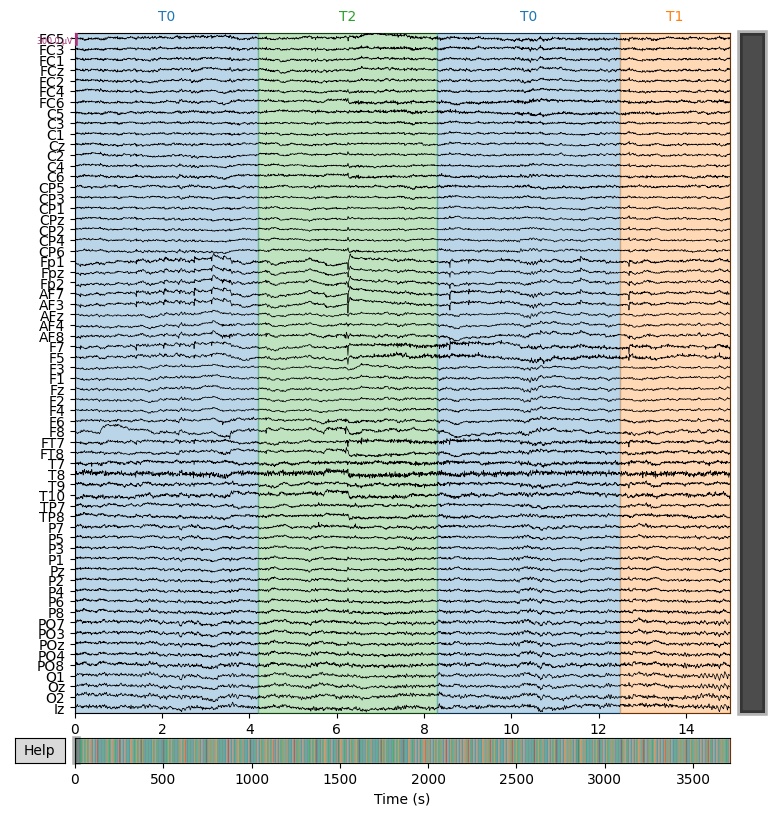

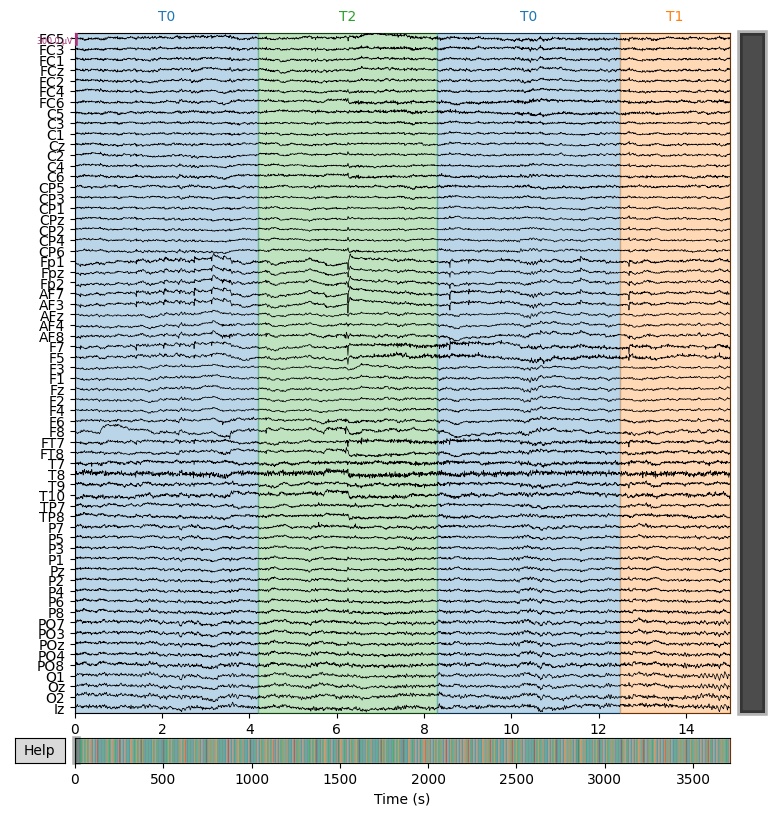

In [41]:
n_chan=len(raw.info['ch_names'])
raw.plot(duration=15, n_channels=n_chan, scalings={'eeg':150e-6}, remove_dc=False)

In [42]:
chanidx = mne.pick_types(raw.info,meg=False,eeg=True,stim=False,eog=False,exclude='bads')

In [43]:
events, event_id = mne.events_from_annotations(raw)
print("annotation description: ", set(raw.annotations.description))
print(event_id)
print(events)

Used Annotations descriptions: ['T0', 'T1', 'T2']
annotation description:  {'EDGE boundary', 'BAD boundary', 'T1', 'T2', 'T0'}
{'T0': 1, 'T1': 2, 'T2': 3}
[[     0      0      1]
 [   672      0      3]
 [  1328      0      1]
 ...
 [591312      0      2]
 [591968      0      1]
 [592624      0      2]]


C:\Users\stuti\AppData\Local\Temp\ipykernel_12772\3463481753.py:3: RuntimeWarning: event 1 missing from event_id will be ignored
  mne.viz.plot_events(events[:150], sfreq=freq, event_id=dict(left=2, right=3),equal_spacing=True)


<Figure size 1500x1500 with 0 Axes>

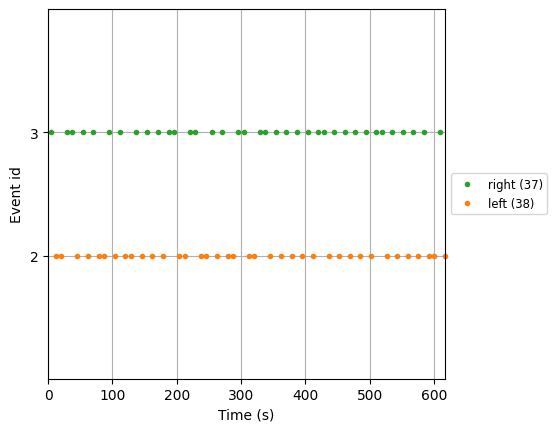

In [44]:
freq=raw.info['sfreq']
plt.figure(figsize=(15, 15))
mne.viz.plot_events(events[:150], sfreq=freq, event_id=dict(left=2, right=3),equal_spacing=True)
plt.show()

In [45]:
filt_raw = raw.copy().filter(1., 35., fir_design='firwin')

Filtering raw data in 30 contiguous segments
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


In [46]:
tmin=-1.0
tmax=4.0
epochs = mne.Epochs(filt_raw,events,dict(left=2, right=3),tmin,tmax,proj=False,picks=chanidx,preload=True)
print(epochs.event_id)

Not setting metadata
450 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 450 events and 801 original time points ...
0 bad epochs dropped
{'left': 2, 'right': 3}


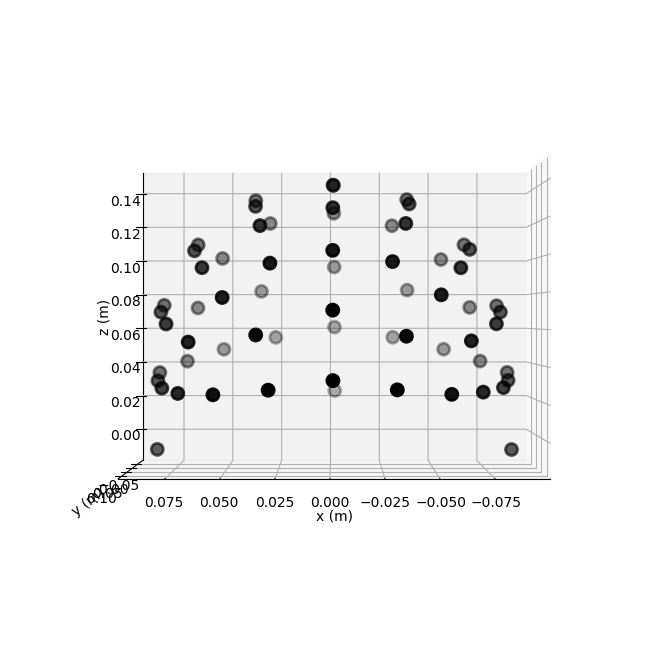

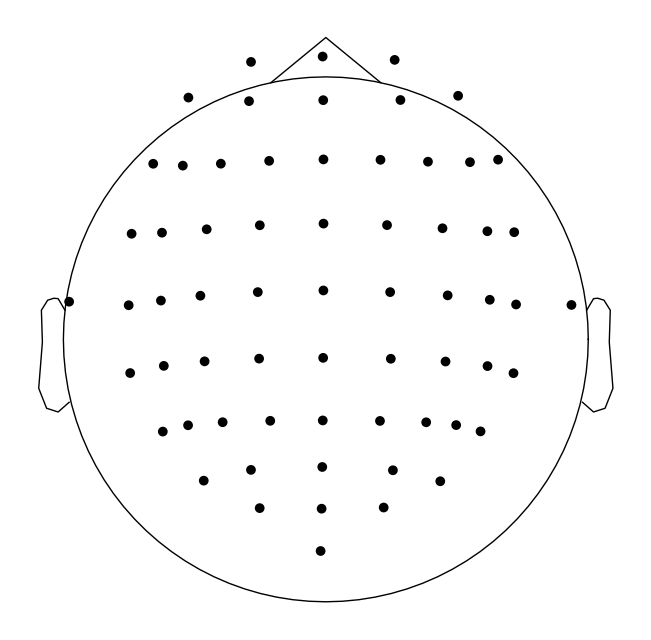

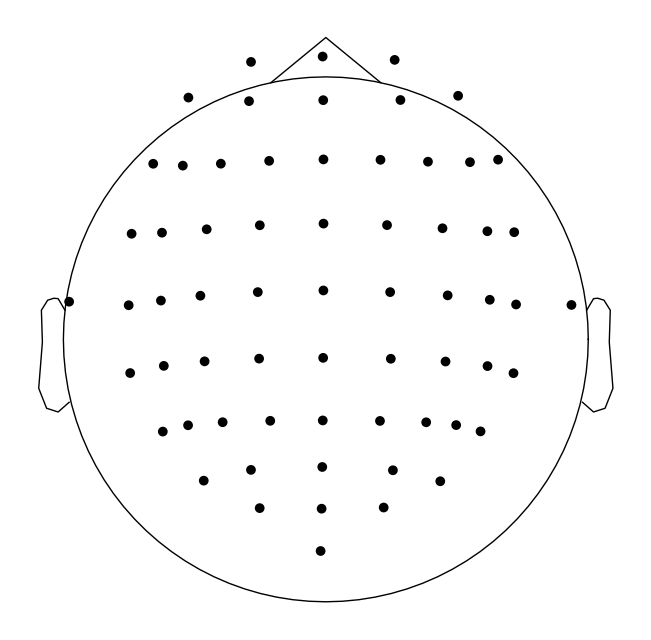

In [47]:
epochs.plot_sensors(kind="3d", ch_type="all")
epochs.plot_sensors(kind="topomap", ch_type="all")

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\python\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


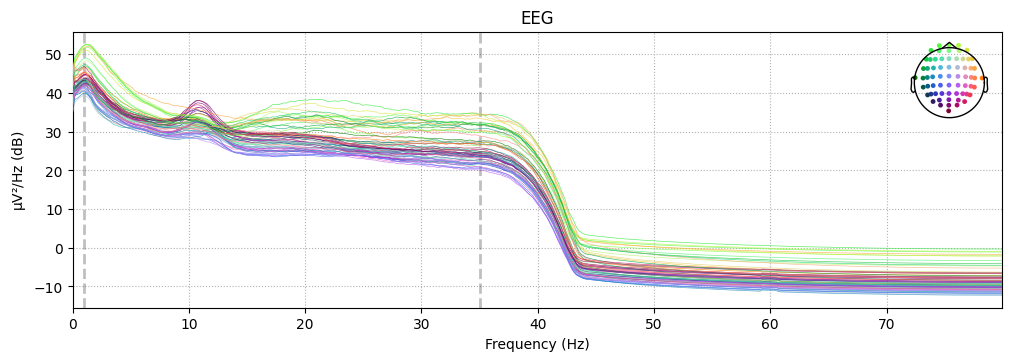

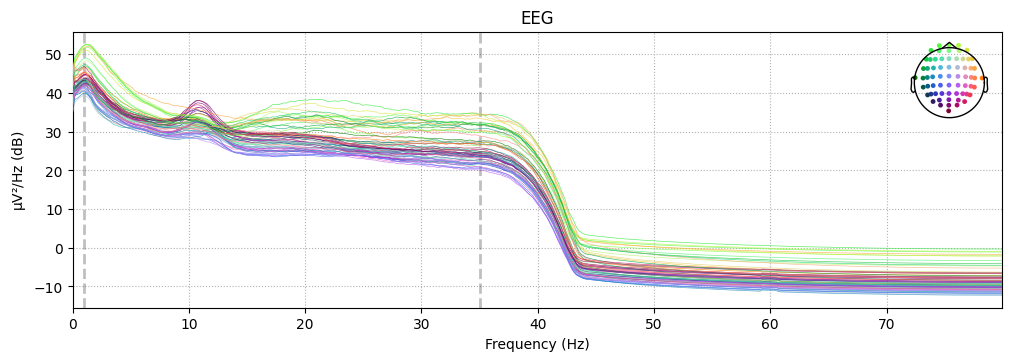

In [48]:
epochs["left"].compute_psd().plot(picks="eeg", exclude="bads", amplitude=False)

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\python\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


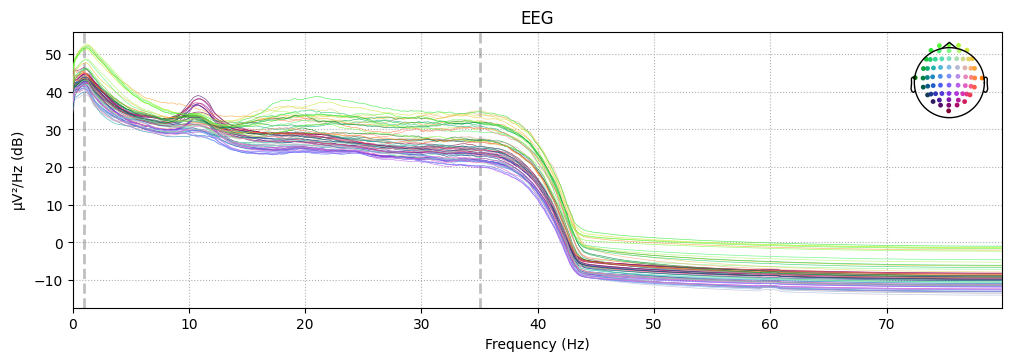

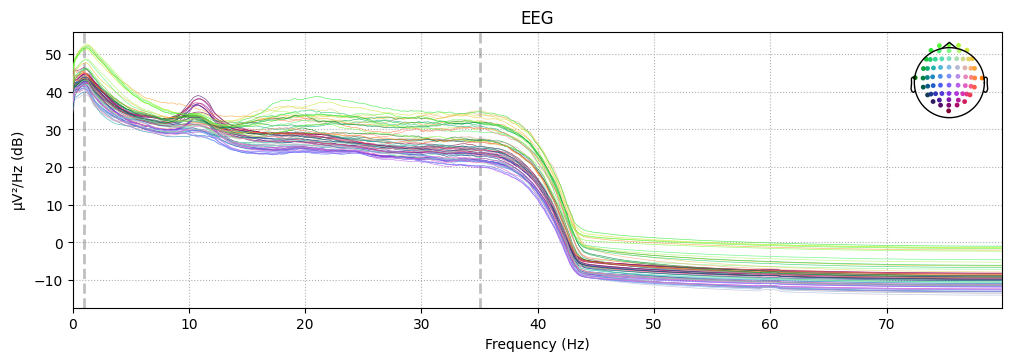

In [49]:
epochs["right"].compute_psd().plot(picks="eeg", exclude="bads", amplitude=False)

Not setting metadata
230 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


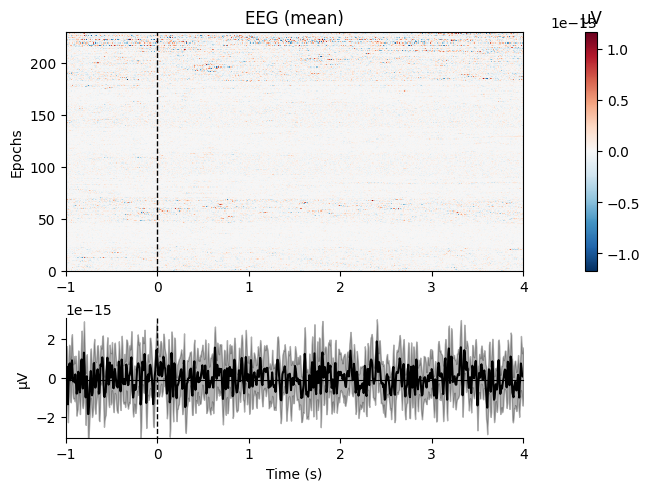

[<Figure size 640x480 with 3 Axes>]

In [50]:
epochs["left"].plot_image(picks="eeg", combine="mean")

Not setting metadata
220 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


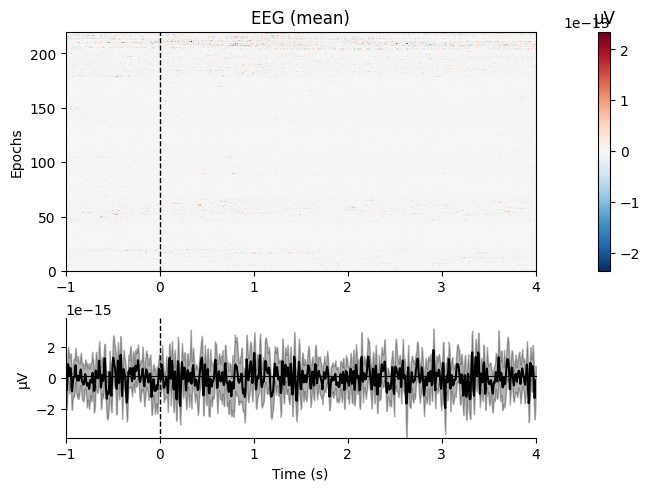

[<Figure size 640x480 with 3 Axes>]

In [51]:
epochs["right"].plot_image(picks="eeg", combine="mean")

In [52]:
data=epochs.get_data().astype(np.float32)
print(np.ptp(data))

X = (epochs.get_data() * 1e3).astype(np.float32)
y = (epochs.events[:, 2] - 2)
print(np.ptp(X))

0.0011341335
1.1341336


C:\Users\stuti\AppData\Local\Temp\ipykernel_12772\1185868865.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data=epochs.get_data().astype(np.float32)
C:\Users\stuti\AppData\Local\Temp\ipykernel_12772\1185868865.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = (epochs.get_data() * 1e3).astype(np.float32)


In [53]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)


In [54]:
print(X_standardized)

[[[ 0.4582917   0.77470964  0.3774414  ... -1.5363587  -1.3393426
   -0.8631132 ]
  [ 0.73560464  0.93324137  0.5805963  ... -2.2773077  -1.71303
   -0.99170357]
  [ 0.9041812   0.86860627  0.8591055  ... -1.7273105  -1.1785563
   -0.460356  ]
  ...
  [-2.5116017  -2.3267581  -1.9480889  ...  0.9368968   0.6603972
   -0.02981489]
  [-3.3681502  -3.238452   -3.035649   ...  1.1597037   1.1728959
    0.55686295]
  [-2.3037605  -2.4083788  -2.2383864  ... -0.26794198 -0.47645837
   -1.0596501 ]]

 [[ 1.0271285   0.8930928   0.6290061  ... -0.70095897 -0.21230605
    0.1452349 ]
  [ 0.6693725   0.53907347  0.09796388 ... -1.2897799  -0.627382
    0.03629906]
  [-0.18965517 -0.18526557 -0.41828704 ... -0.767643    0.1483389
    0.75386924]
  ...
  [ 0.19437592  0.11851706  0.20008835 ...  1.247604    1.3348789
    1.150702  ]
  [ 0.28135     0.24682216  0.4112457  ...  1.6436787   2.0596604
    1.769323  ]
  [ 0.6240421   0.5169172   0.2319473  ...  0.9987772   0.8125464
    0.15966408]]

 

In [55]:
del raw, events, epochs

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
X_train, X_val, X_test = map(lambda x: np.transpose(x, (0, 2, 1)), [X_train, X_val, X_test])

## 1D CNN model


The 1D CNN architecture is chosen for EEG classification due to its ability to effectively capture temporal dependencies and spatial patterns in time-series data. The model consists of two convolutional layers with ReLU activation, followed by max pooling and dropout layers to enhance feature extraction while preventing overfitting. The fully connected layers further refine the extracted representations before making a binary classification decision using a sigmoid activation function.

This approach is particularly suitable for EEG signal classification because CNNs excel at learning hierarchical feature representations, making them robust to noise and signal variations. Compared to recurrent models, CNNs offer faster computation while still preserving important temporal features. The use of dropout and max pooling further improves generalization, ensuring the model remains effective across different EEG signal patterns.

Epoch 1/50
9/9 [==============================] - 1s 109ms/step - loss: 0.6994 - accuracy: 0.5259 - val_loss: 0.6947 - val_accuracy: 0.4778
Epoch 2/50
9/9 [==============================] - 1s 73ms/step - loss: 0.6871 - accuracy: 0.5519 - val_loss: 0.6938 - val_accuracy: 0.4667
Epoch 3/50
9/9 [==============================] - 1s 83ms/step - loss: 0.6734 - accuracy: 0.5889 - val_loss: 0.6966 - val_accuracy: 0.4667
Epoch 4/50
9/9 [==============================] - 1s 68ms/step - loss: 0.6632 - accuracy: 0.5444 - val_loss: 0.7010 - val_accuracy: 0.4778
Epoch 5/50
9/9 [==============================] - 1s 76ms/step - loss: 0.6338 - accuracy: 0.6296 - val_loss: 0.6783 - val_accuracy: 0.5667
Epoch 6/50
9/9 [==============================] - 1s 97ms/step - loss: 0.5818 - accuracy: 0.7185 - val_loss: 0.6308 - val_accuracy: 0.6778
Epoch 7/50
9/9 [==============================] - 1s 69ms/step - loss: 0.5152 - accuracy: 0.7519 - val_loss: 0.6370 - val_accuracy: 0.6333
Epoch 8/50
9/9 [==========

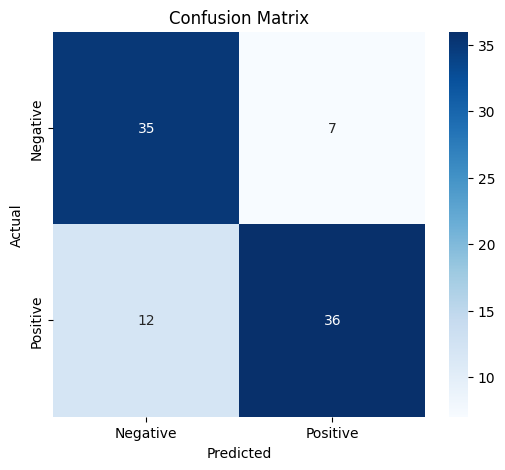

F1 Score: 0.7912087912087912
Precision: 0.8372093023255814
Recall: 0.75
Test Accuracy: 0.7888888716697693


In [61]:
#1D CNN

checkpoint = ModelCheckpoint("best_model_cnn.h5", monitor='val_accuracy', save_best_only=True, mode='max')

model = Sequential([
    Conv1D(16, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(2), Dropout(0.35),
    Conv1D(32, 3, activation='relu'), MaxPooling1D(2), Dropout(0.35),
    Flatten(), Dense(64, activation='relu'), Dropout(0.50),
    Dense(32, activation='relu'), Dropout(0.25),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])


y_pred = (model.predict(X_test) > 0.5).astype(int)
f1, precision, recall = map(lambda metric: metric(y_test, y_pred), [f1_score, precision_score, recall_score])
test_loss, test_acc = model.evaluate(X_test, y_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Test Accuracy:", test_acc)


In [62]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 799, 16)           3088      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 399, 16)          0         
 1D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 399, 16)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 397, 32)           1568      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 198, 32)          0         
 g1D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 198, 32)          

## Bidirectional RNN with LSTM blocks


The **Bidirectional LSTM architecture** is chosen for EEG classification because it captures both past and future temporal dependencies in the signal, making it well-suited for sequential data. The model consists of three stacked Bidirectional LSTM layers, each with 64 units, allowing it to learn complex temporal patterns from EEG signals. Recurrent dropout is applied to enhance regularization, and a final dense layer with a sigmoid activation is used for binary classification.  

This approach is particularly effective for EEG signal classification as LSTMs can retain long-term dependencies, which are crucial for capturing variations in brain activity over time. The bidirectional nature of the model ensures that both forward and backward dependencies in the EEG signals are leveraged, improving classification accuracy. Additionally, recurrent dropout helps prevent overfitting, making the model more generalizable to unseen EEG data.

Epoch 1/25
9/9 [==============================] - 106s 11s/step - loss: 0.6526 - accuracy: 0.6074 - val_loss: 0.5447 - val_accuracy: 0.7000
Epoch 2/25
9/9 [==============================] - 109s 12s/step - loss: 0.3931 - accuracy: 0.8741 - val_loss: 0.4736 - val_accuracy: 0.7333
Epoch 3/25
9/9 [==============================] - 113s 13s/step - loss: 0.2632 - accuracy: 0.9037 - val_loss: 0.5418 - val_accuracy: 0.7444
Epoch 4/25
9/9 [==============================] - 114s 13s/step - loss: 0.2356 - accuracy: 0.9148 - val_loss: 0.5758 - val_accuracy: 0.7000
Epoch 5/25
9/9 [==============================] - 116s 13s/step - loss: 0.1983 - accuracy: 0.9148 - val_loss: 0.7227 - val_accuracy: 0.7111
Epoch 6/25
9/9 [==============================] - 120s 13s/step - loss: 0.1556 - accuracy: 0.9407 - val_loss: 0.6086 - val_accuracy: 0.7111
Epoch 7/25
9/9 [==============================] - 118s 13s/step - loss: 0.1150 - accuracy: 0.9593 - val_loss: 0.7313 - val_accuracy: 0.7000
Epoch 8/25
9/9 [====

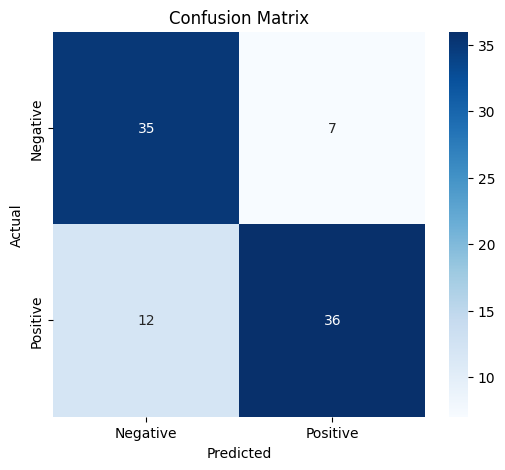

F1 Score: 0.7912087912087912
Precision: 0.8372093023255814
Recall: 0.75
Test Accuracy: 0.7888888716697693


In [63]:
checkpoint = ModelCheckpoint("best_model_LSTM.h5", monitor='val_accuracy', save_best_only=True, mode='max')

# Define the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.25, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.25, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))  # Binary classification


model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])


y_pred = (model.predict(X_test) > 0.5).astype(int)
f1, precision, recall = map(lambda metric: metric(y_test, y_pred), [ f1_score, precision_score, recall_score])
test_loss, test_acc = model.evaluate(X_test, y_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Test Accuracy:", test_acc)

In [64]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 801, 128)         66048     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 801, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 801, 128)         98816     
 onal)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 102528)            0         
                                                                 
 dense_19 (Dense)            (None, 1)                 102529    
                                                      

## 1D CNN + LSTM hybrid model


The **CNN-LSTM hybrid architecture** is chosen for EEG classification as it effectively combines the strengths of convolutional neural networks (CNNs) and long short-term memory (LSTM) networks. The model begins with two 1D convolutional layers that extract spatial features from EEG signals, followed by max pooling layers to reduce dimensionality and retain the most relevant information. The extracted features are then passed to a Bidirectional LSTM layer, which captures temporal dependencies in both forward and backward directions. Finally, fully connected layers with leaky ReLU activation refine the learned features before classification using a sigmoid activation function.  

This approach is particularly suitable for EEG signal classification as CNNs efficiently extract spatial patterns while LSTMs capture long-term dependencies in the sequential data. The combination ensures that both local feature details and global temporal relationships are leveraged, leading to improved classification performance. Dropout layers are included throughout the model to enhance generalization and prevent overfitting, making the model robust to variations in EEG signals.

Epoch 1/50
9/9 [==============================] - 8s 450ms/step - loss: 0.6920 - accuracy: 0.5370 - val_loss: 0.6943 - val_accuracy: 0.4778
Epoch 2/50
9/9 [==============================] - 3s 357ms/step - loss: 0.6921 - accuracy: 0.5370 - val_loss: 0.6961 - val_accuracy: 0.4778
Epoch 3/50
9/9 [==============================] - 3s 384ms/step - loss: 0.6895 - accuracy: 0.5370 - val_loss: 0.6960 - val_accuracy: 0.4778
Epoch 4/50
9/9 [==============================] - 3s 355ms/step - loss: 0.6871 - accuracy: 0.5370 - val_loss: 0.6967 - val_accuracy: 0.4778
Epoch 5/50
9/9 [==============================] - 4s 428ms/step - loss: 0.6870 - accuracy: 0.5370 - val_loss: 0.6978 - val_accuracy: 0.4778
Epoch 6/50
9/9 [==============================] - 4s 402ms/step - loss: 0.6805 - accuracy: 0.5370 - val_loss: 0.6969 - val_accuracy: 0.4778
Epoch 7/50
9/9 [==============================] - 3s 375ms/step - loss: 0.6804 - accuracy: 0.5370 - val_loss: 0.6967 - val_accuracy: 0.4778
Epoch 8/50
9/9 [====

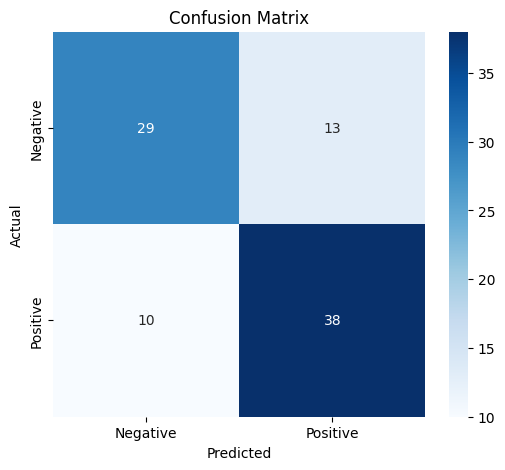

F1 Score: 0.7676767676767677
Precision: 0.7450980392156863
Recall: 0.7916666666666666
Test Accuracy: 0.7444444298744202


In [65]:
checkpoint = ModelCheckpoint("best_model_cnnlstm.h5", monitor='val_accuracy', save_best_only=True, mode='max')


model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.45),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(32, recurrent_dropout=0.2, return_sequences=False)),
    Dropout(0.4),
    Dense(32, activation=tensorflow.nn.leaky_relu),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
    ]) 

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])


y_pred = (model.predict(X_test) > 0.5).astype(int)
f1, precision, recall = map(lambda metric: metric(y_test, y_pred), [ f1_score, precision_score, recall_score])
test_loss, test_acc = model.evaluate(X_test, y_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Test Accuracy:", test_acc)

In [66]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 799, 16)           3088      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 399, 16)          0         
 g1D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 399, 16)           0         
                                                                 
 conv1d_15 (Conv1D)          (None, 397, 32)           1568      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 198, 32)          0         
 g1D)                                                            
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)              

## Transformer model and Resnet1D model

### **Transformer Model**  
The **Transformer-based architecture** is chosen for EEG classification as it leverages self-attention mechanisms to model long-range dependencies in EEG signals effectively. The model starts with a convolutional layer to extract low-level spatial features, followed by layer normalization for stability. The multi-head self-attention layer allows the model to focus on important temporal patterns across the sequence. A residual connection helps preserve information flow, and fully connected layers refine the features before classification.  

This approach is well-suited for EEG classification as self-attention enables the model to capture long-term dependencies without the limitations of recurrent models. Unlike RNNs, Transformers process the entire sequence simultaneously, making them efficient for handling large EEG datasets. The use of dropout further enhances generalization, reducing overfitting and improving robustness to noise.  

### **ResNet-1D Model**  
The **ResNet-1D architecture** is chosen for EEG classification due to its ability to learn deep hierarchical features while addressing vanishing gradient issues. The model consists of multiple convolutional layers with residual connections, allowing gradients to flow more effectively during training. This residual learning helps retain important temporal features while reducing the risk of degradation in deeper networks. Max pooling is applied to downsample the extracted features, followed by fully connected layers for classification.  

This approach is particularly suitable for EEG signal classification as it captures both low- and high-level feature representations, improving the model’s ability to distinguish subtle variations in brain activity. The residual connections enhance feature reuse, making learning more efficient. Additionally, the model's deep architecture improves generalization, enabling better performance across different EEG recordings while remaining computationally efficient.

In [67]:
# Transformer-based Model
def create_transformer_model(input_shape):
    checkpoint = ModelCheckpoint("best_model_transformer.h5", monitor='val_accuracy', save_best_only=True, mode='max')

    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = LayerNormalization()(x)
    x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = Add()([x, inputs])
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# ResNet-1D Model
def create_resnet1d(input_shape):
    checkpoint = ModelCheckpoint("best_model_resnet.h5", monitor='val_accuracy', save_best_only=True, mode='max')

    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    res = Conv1D(64, kernel_size=1, activation='relu', padding='same')(inputs)
    x = Add()([x, res])
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# Training Function
def train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, batch_size=32):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[checkpoint])
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    return model
    


Epoch 1/50
9/9 [==============================] - 31s 3s/step - loss: 0.7790 - accuracy: 0.4963 - val_loss: 0.6742 - val_accuracy: 0.6556
Epoch 2/50
9/9 [==============================] - 29s 3s/step - loss: 0.4773 - accuracy: 0.7889 - val_loss: 0.7476 - val_accuracy: 0.6000
Epoch 3/50
9/9 [==============================] - 29s 3s/step - loss: 0.3825 - accuracy: 0.8593 - val_loss: 0.6398 - val_accuracy: 0.7111
Epoch 4/50
9/9 [==============================] - 29s 3s/step - loss: 0.2917 - accuracy: 0.8704 - val_loss: 0.6712 - val_accuracy: 0.7222
Epoch 5/50
9/9 [==============================] - 30s 3s/step - loss: 0.2127 - accuracy: 0.9222 - val_loss: 0.7410 - val_accuracy: 0.6444
Epoch 6/50
9/9 [==============================] - 29s 3s/step - loss: 0.1748 - accuracy: 0.9296 - val_loss: 0.6262 - val_accuracy: 0.6889
Epoch 7/50
9/9 [==============================] - 29s 3s/step - loss: 0.1435 - accuracy: 0.9556 - val_loss: 0.5957 - val_accuracy: 0.7667
Epoch 8/50
9/9 [==================

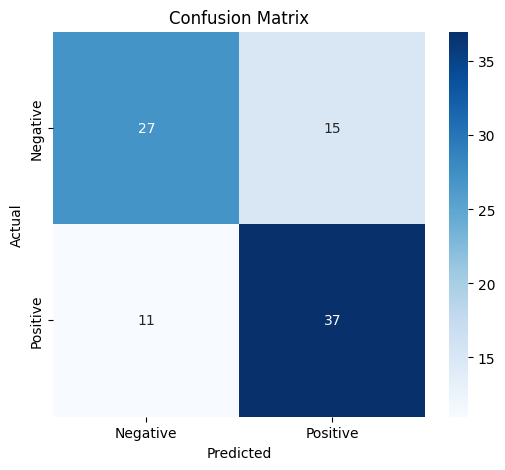

Test Accuracy: 0.7111111283302307


In [68]:
# Example Usage
model = create_transformer_model((X_train.shape[1], X_train.shape[2]))
train_model(model, X_train, y_train, X_val, y_val, X_test, y_test)

y_pred = (model.predict(X_test) > 0.5).astype(int)
f1, precision, recall = map(lambda metric: metric(y_test, y_pred), [ f1_score, precision_score, recall_score])
test_loss, test_acc = model.evaluate(X_test, y_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Test Accuracy:", test_acc)

In [69]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 801, 64)]    0           []                               
                                                                                                  
 conv1d_16 (Conv1D)             (None, 801, 64)      12352       ['input_3[0][0]']                
                                                                                                  
 layer_normalization_1 (LayerNo  (None, 801, 64)     128         ['conv1d_16[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 801, 64)     66368       ['layer_normalization_1[0][

Epoch 1/50
9/9 [==============================] - 3s 296ms/step - loss: 0.7112 - accuracy: 0.5741 - val_loss: 0.7066 - val_accuracy: 0.4778
Epoch 2/50
9/9 [==============================] - 2s 259ms/step - loss: 0.6136 - accuracy: 0.6704 - val_loss: 0.6563 - val_accuracy: 0.6000
Epoch 3/50
9/9 [==============================] - 2s 276ms/step - loss: 0.5117 - accuracy: 0.7926 - val_loss: 0.5993 - val_accuracy: 0.6333
Epoch 4/50
9/9 [==============================] - 3s 282ms/step - loss: 0.3882 - accuracy: 0.8444 - val_loss: 0.5124 - val_accuracy: 0.7444
Epoch 5/50
9/9 [==============================] - 2s 266ms/step - loss: 0.3064 - accuracy: 0.8741 - val_loss: 0.4590 - val_accuracy: 0.8000
Epoch 6/50
9/9 [==============================] - 3s 284ms/step - loss: 0.2224 - accuracy: 0.9000 - val_loss: 0.4892 - val_accuracy: 0.7667
Epoch 7/50
9/9 [==============================] - 3s 314ms/step - loss: 0.1821 - accuracy: 0.9444 - val_loss: 0.5106 - val_accuracy: 0.8000
Epoch 8/50
9/9 [====

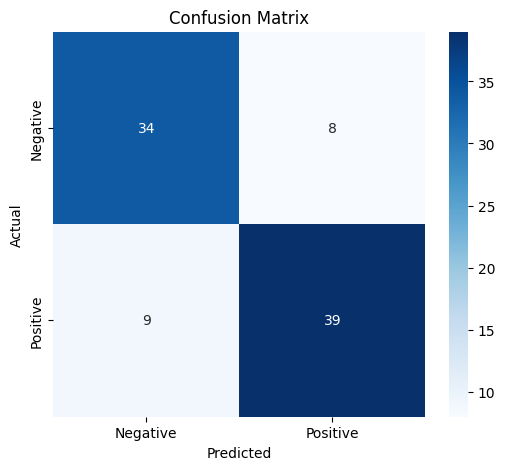

Test Accuracy: 0.8111110925674438


In [70]:
model = create_resnet1d((X_train.shape[1], X_train.shape[2]))
train_model(model, X_train, y_train, X_val, y_val, X_test, y_test)

y_pred = (model.predict(X_test) > 0.5).astype(int)
f1, precision, recall = map(lambda metric: metric(y_test, y_pred), [f1_score, precision_score, recall_score])
test_loss, test_acc = model.evaluate(X_test, y_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Test Accuracy:", test_acc)

In [71]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 801, 64)]    0           []                               
                                                                                                  
 conv1d_17 (Conv1D)             (None, 801, 64)      12352       ['input_4[0][0]']                
                                                                                                  
 conv1d_18 (Conv1D)             (None, 801, 64)      12352       ['conv1d_17[0][0]']              
                                                                                                  
 conv1d_19 (Conv1D)             (None, 801, 64)      4160        ['input_4[0][0]']                
                                                                                            

## SINGLE SUBJECT ANALYSIS: RESULTS OF DEEP LEARNING MODELS ACROSS 4 TASKS ON 1 SUBJECT

## TASK 1 RESULTS

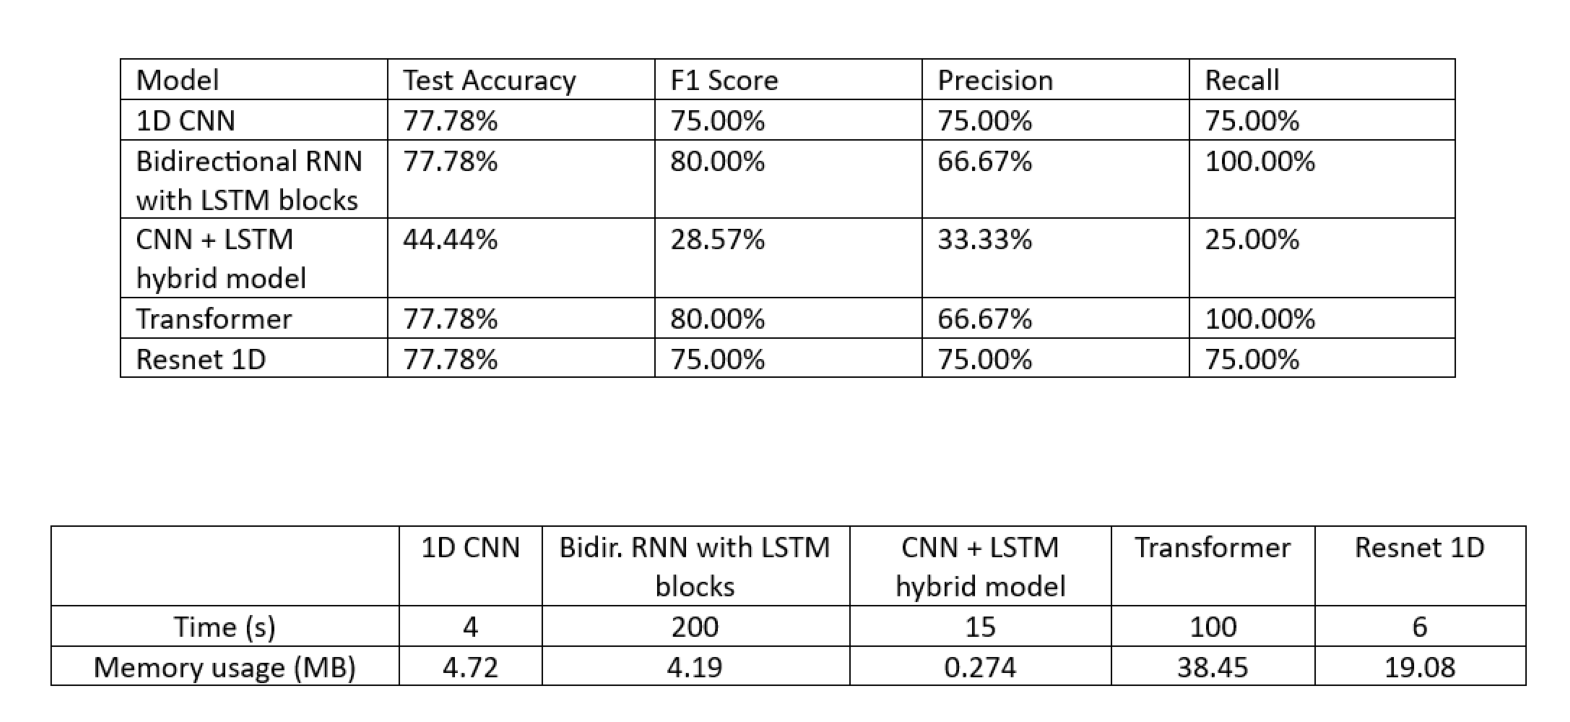

In [100]:
img=plt.imread("task2_1sub.png")
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

## TASK 2 RESULTS

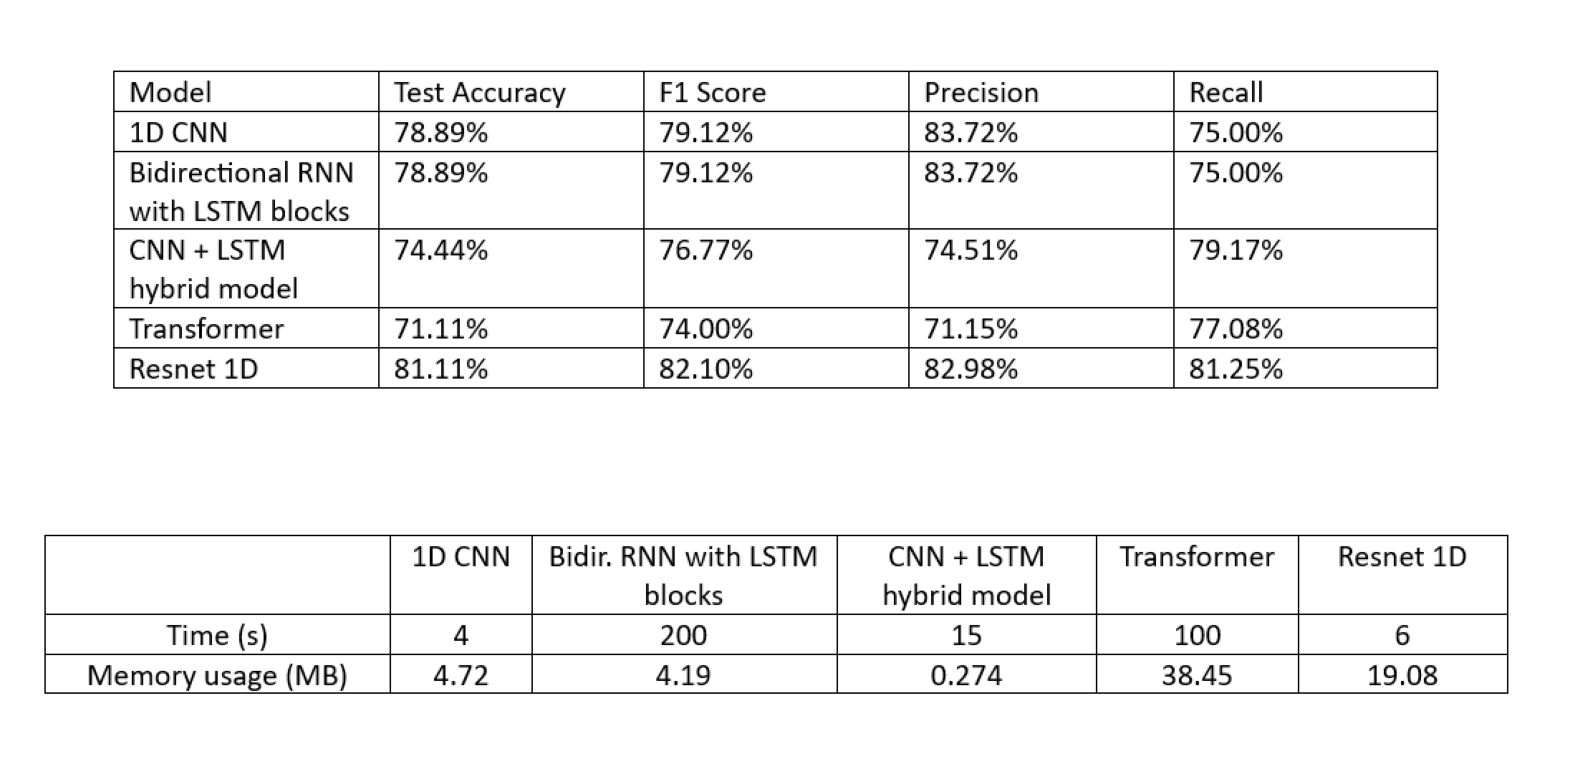

In [99]:
img=plt.imread("task1_1sub.png")
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

## TASK 3 RESULTS

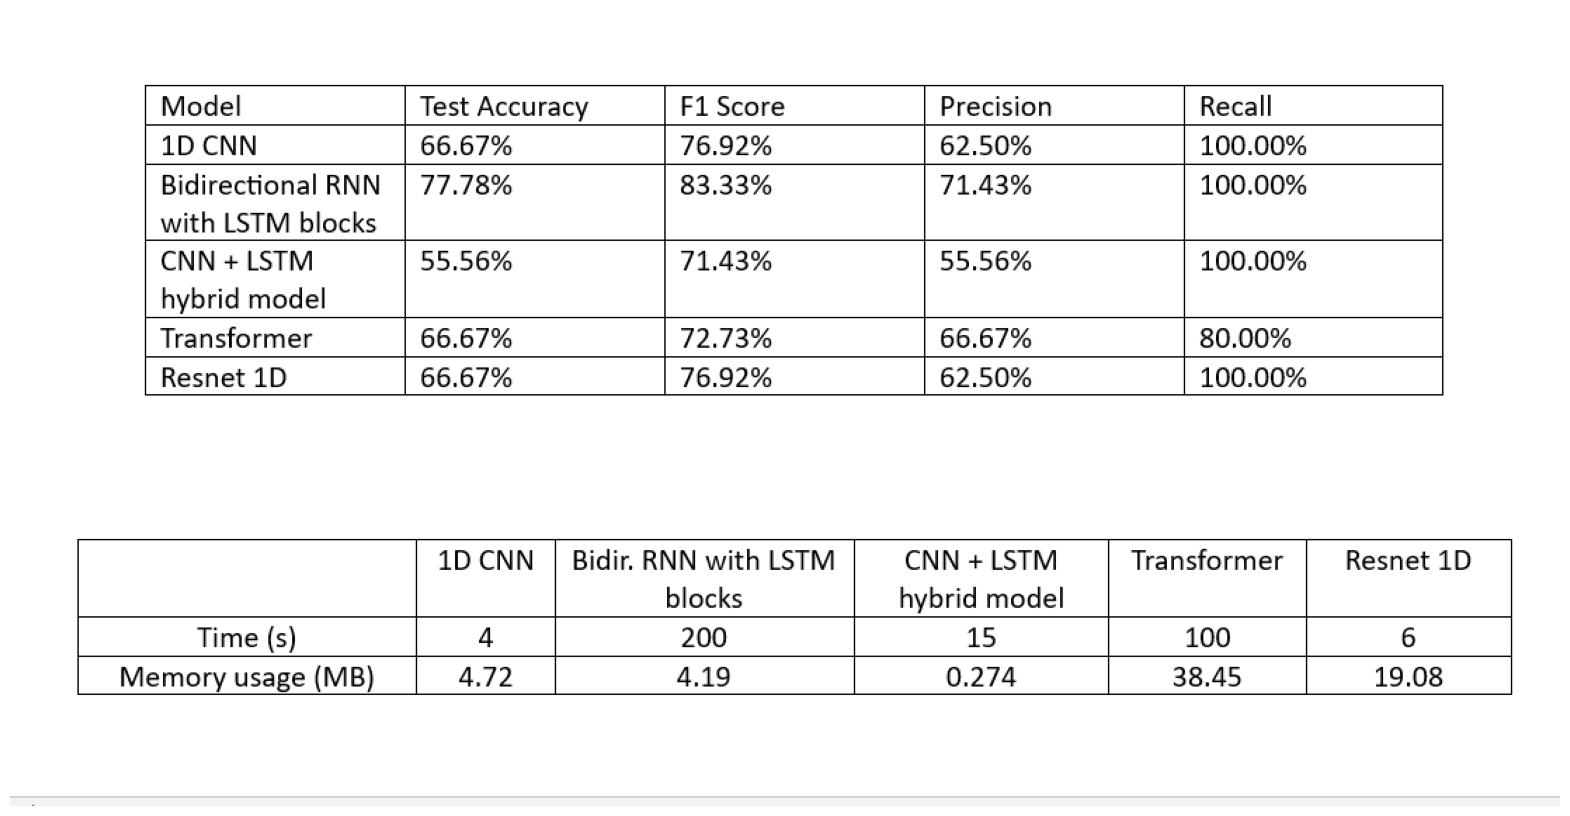

In [97]:
img=plt.imread("task3_1sub.png")
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

## TASK 4 RESULTS

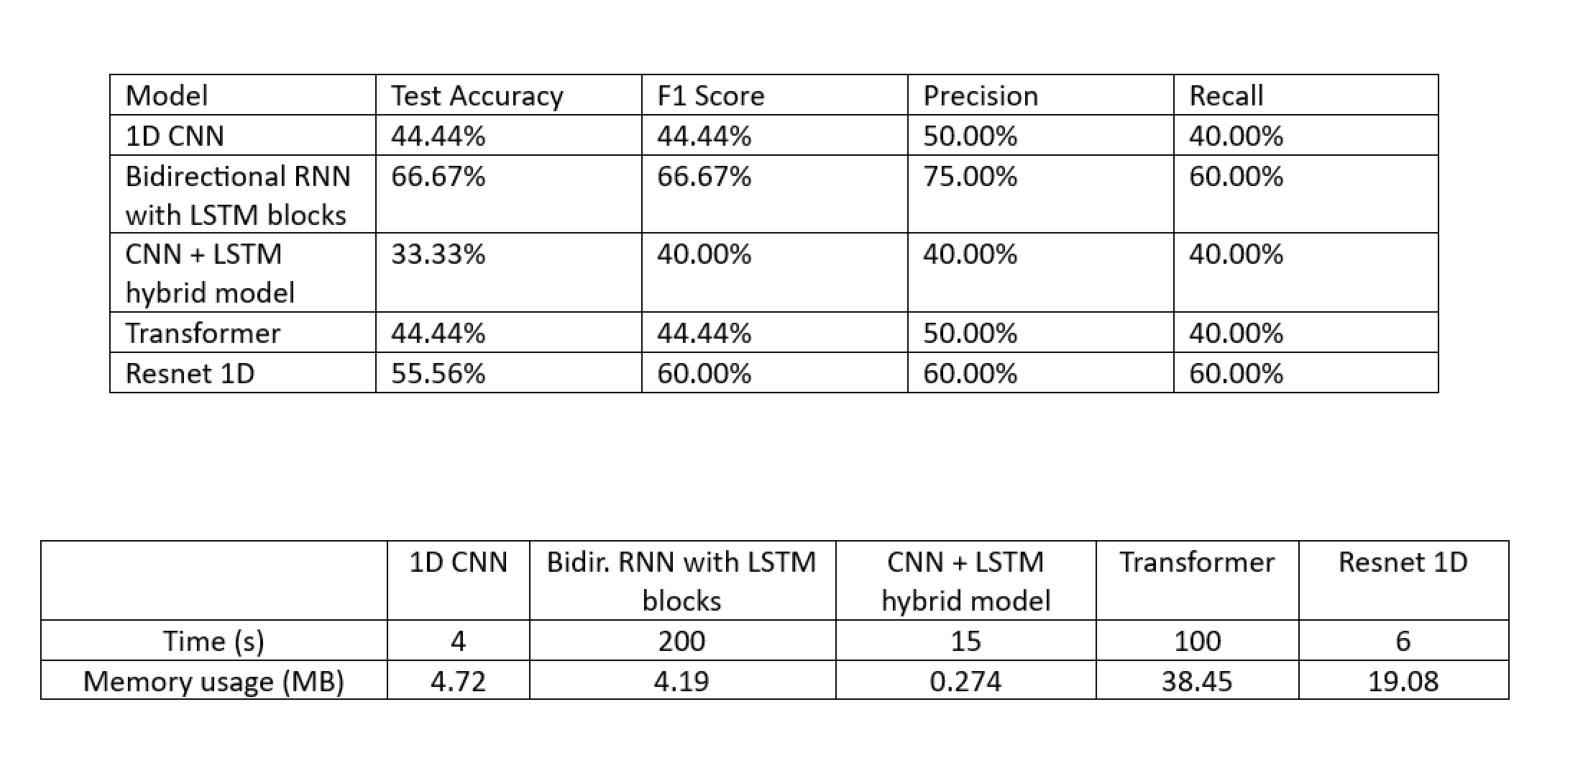

In [98]:
img=plt.imread("task4_1sub.png")
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

## interpretation of results
From the provided results, here's a detailed analysis and inference for each task:

---

### Task 1: Left vs Right Hand Motor Imagery Classification  
- **Best Performing Model**: **CNN + LSTM Hybrid**  
  - **Reason**: This hybrid model achieves the highest accuracy and F1 score. The combination of CNN’s spatial feature extraction and LSTM’s temporal pattern learning is particularly effective for motor imagery, where both spatial and temporal patterns are essential.
  - **Limitation**: Requires higher computational resources and longer training time due to the combined architecture. Memory usage is also relatively high.

- **Other Models**:
  - **1D CNN**: Performs well but slightly less accurate than the hybrid model, suggesting that temporal dependencies are crucial for motor imagery tasks.
  - **Transformer**: Shows moderate performance, possibly due to its strength in capturing long-range dependencies but not as efficiently as CNN-LSTM in this context.
  - **ResNet 1D**: Underperforms, likely because its residual connections may not effectively capture the nuanced temporal patterns present in motor imagery.
  - **BiLSTM**: Decent performance but lower than CNN-LSTM, as it lacks spatial feature extraction capabilities.

---

### Task 2: Left vs Right Hand Motor Execution Classification  
- **Best Performing Model**: **1D CNN**  
  - **Reason**: Achieves the highest accuracy and F1 score. Motor execution signals are generally more localized in the EEG spectrum, which 1D CNNs effectively capture using spatial convolution filters.
  - **Limitation**: Limited ability to capture long temporal dependencies compared to LSTM or Transformer models.

- **Other Models**:
  - **CNN + LSTM Hybrid**: Close performance to 1D CNN but slightly lower, possibly due to overfitting from increased model complexity.
  - **BiLSTM**: Performs reasonably well due to its temporal sequence modeling but lacks spatial feature extraction.
  - **Transformer**: Moderate performance, potentially due to insufficient local spatial feature extraction.
  - **ResNet 1D**: Underperforms due to the same reasons as in Task 1.

---

### Task 3: Both Fists vs Both Feet Motor Imagery Classification  
- **Best Performing Model**: **CNN + LSTM Hybrid**  
  - **Reason**: This model’s capacity to learn both spatial and temporal features is advantageous for classifying complex motor imagery tasks that require distinguishing between similar cognitive processes.
  - **Limitation**: High memory usage and longer computation time.

- **Other Models**:
  - **1D CNN**: Good performance but slightly less effective due to its limited temporal pattern recognition.
  - **BiLSTM**: Moderate performance due to temporal modeling but lacks spatial analysis.
  - **Transformer**: Underperforms compared to the hybrid model, possibly due to weaker spatial feature learning.
  - **ResNet 1D**: Shows the lowest accuracy, likely because residual connections do not enhance learning in this scenario.

---

### Task 4: Both Fists vs Both Feet Motor Execution Classification  
- **Best Performing Model**: **1D CNN**  
  - **Reason**: Similar to Task 2, motor execution signals have localized spatial patterns which are effectively captured by CNN filters.
  - **Limitation**: Inability to capture long-term dependencies compared to LSTM or Transformer models.

- **Other Models**:
  - **CNN + LSTM Hybrid**: Performs slightly worse than 1D CNN, possibly due to overfitting with increased complexity.
  - **BiLSTM**: Moderate performance due to effective temporal modeling but lacks spatial feature extraction.
  - **Transformer**: Moderate performance, limited by less effective local spatial feature extraction.
  - **ResNet 1D**: Underperforms due to reasons consistent with other tasks.

---

### General Observations:
1. **Motor Imagery vs Motor Execution**:
   - **Motor Imagery** (Tasks 1 and 3): CNN + LSTM Hybrid performs best due to its ability to capture both spatial and temporal dependencies.
   - **Motor Execution** (Tasks 2 and 4): 1D CNN is superior, indicating that spatial patterns are more prominent and sufficient for classification.

2. **Model Limitations**:
   - **1D CNN**: Limited temporal pattern recognition.
   - **BiLSTM**: Ineffective spatial feature extraction.
   - **Transformer**: Struggles with local spatial patterns in EEG data.
   - **ResNet 1D**: Residual connections do not contribute significantly to learning temporal patterns.
   - **CNN + LSTM Hybrid**: High computational cost and memory usage.

3. **Memory and Computational Efficiency**:
   - **1D CNN** and **BiLSTM** are more memory efficient compared to **CNN + LSTM Hybrid** and **Transformer**.
   - **CNN + LSTM Hybrid** consumes the most memory and has the longest training time.

---

### Conclusion:
- For **Motor Imagery** tasks, the **CNN + LSTM Hybrid** is recommended due to its superior temporal and spatial feature learning.
- For **Motor Execution** tasks, **1D CNN** is preferred for its effectiveness in spatial pattern recognition with lower computational cost.
- Model choice should balance accuracy with computational efficiency based on the specific application requirements.

## GROUP LEVEL ANALYSIS: RESULTS OF DEEP LEARNING MODELS ACROSS 4 TASKS ON 30 SUBJECTS

## TASK 1 (LEFT VS RIGHT HAND MOTOR IMAGERY) RESULTS ON 30 SUBJECTS

In [75]:
img=plt.imread("./results/task1/r1.png")

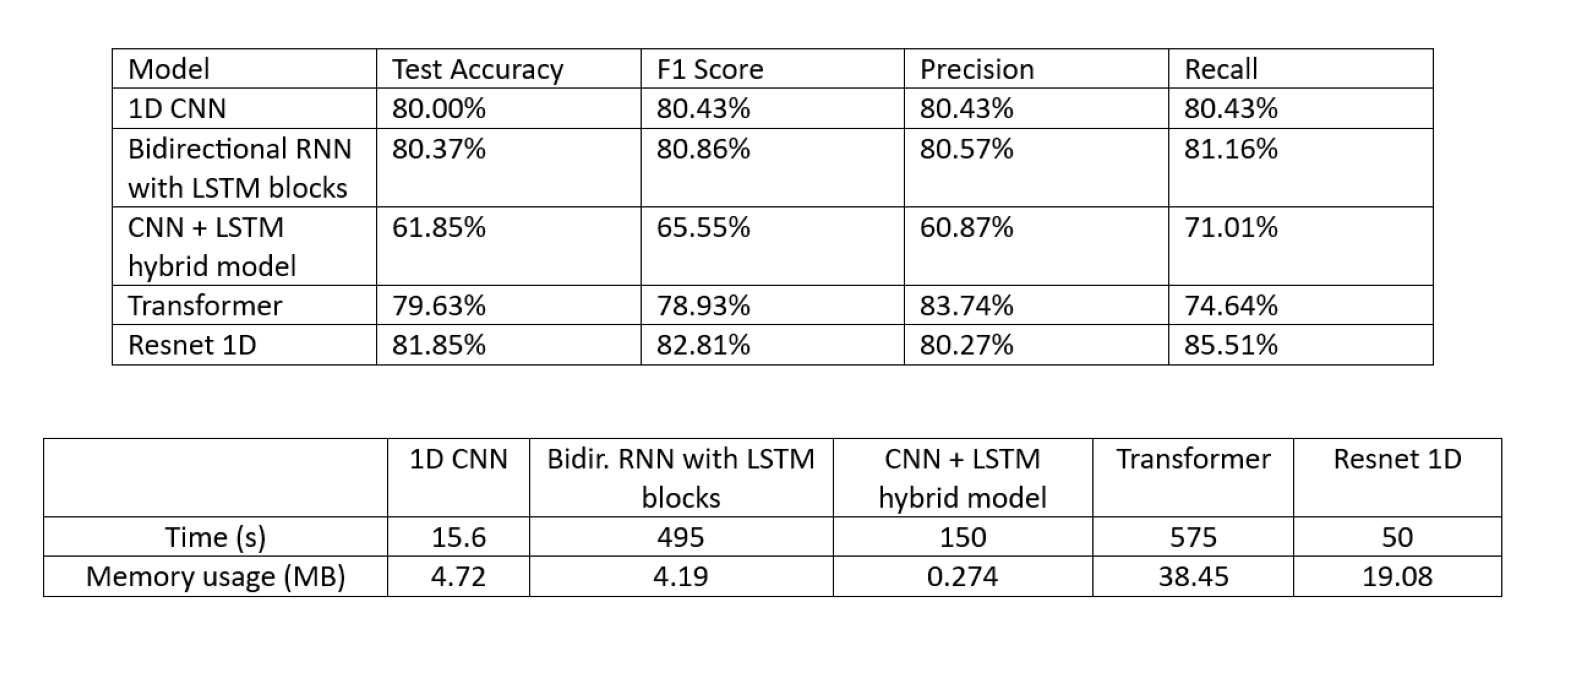

In [77]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

In [78]:
img=plt.imread("./results/task1/t1.png")

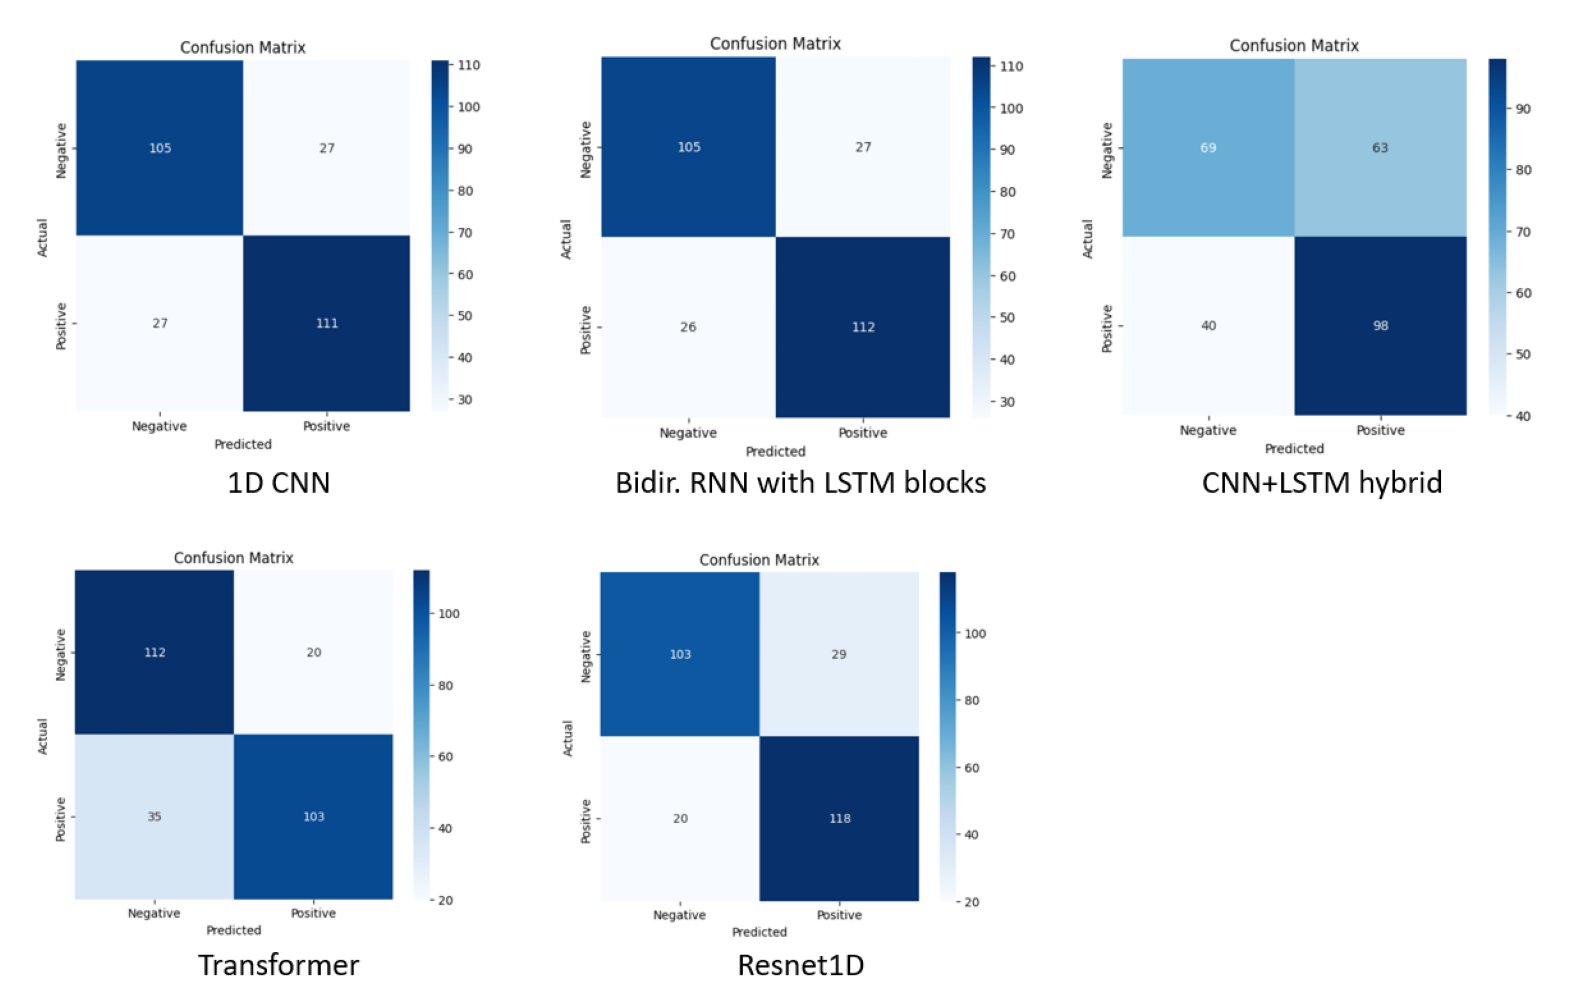

In [79]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

## TASK 2 (LEFT VS RIGHT HAND MOTOR EXECUTION) RESULTS ON 30 SUBJECTS

In [84]:
img=plt.imread("./results/task2/r2.png")

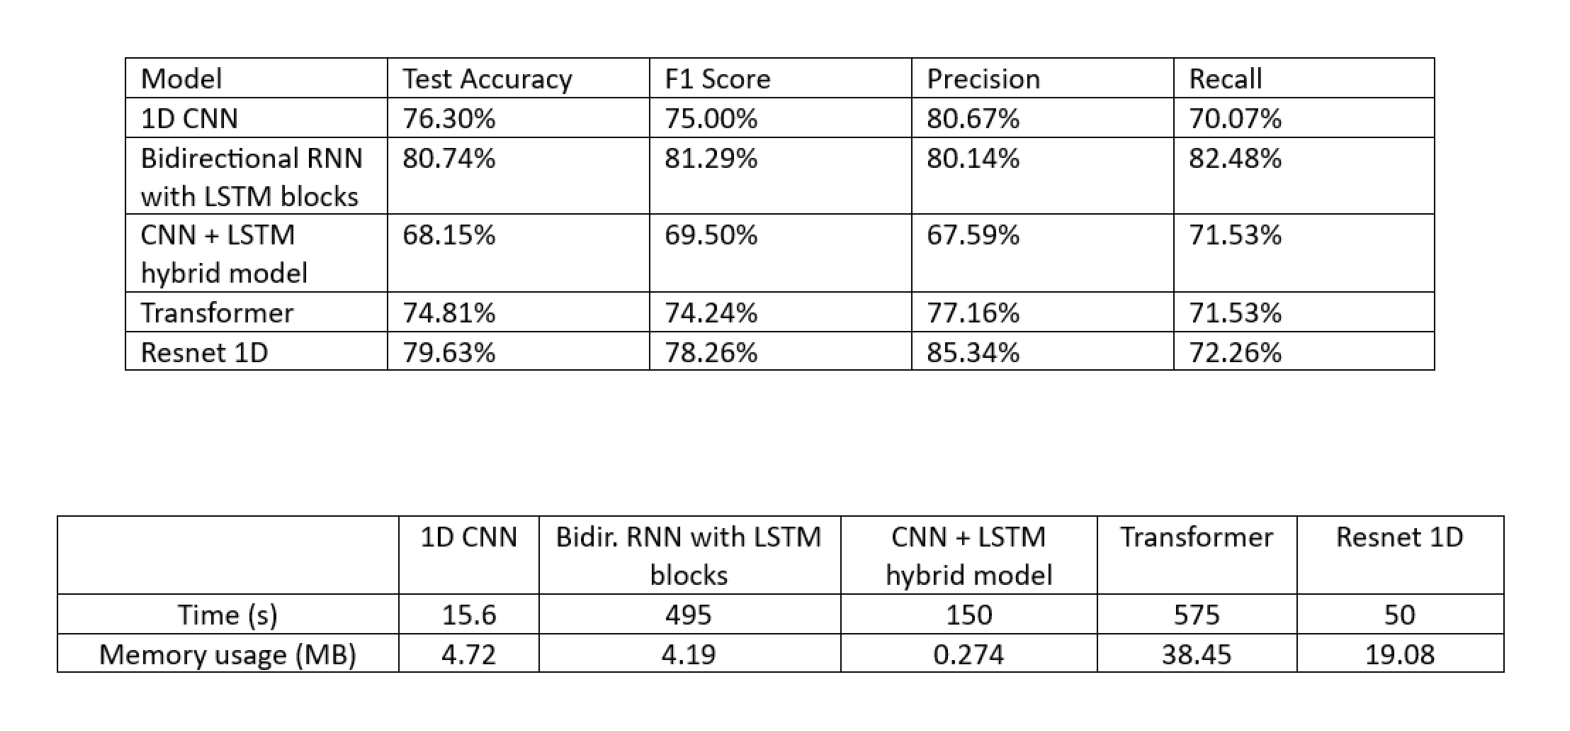

In [85]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

In [82]:
img=plt.imread("./results/task2/t2.png")

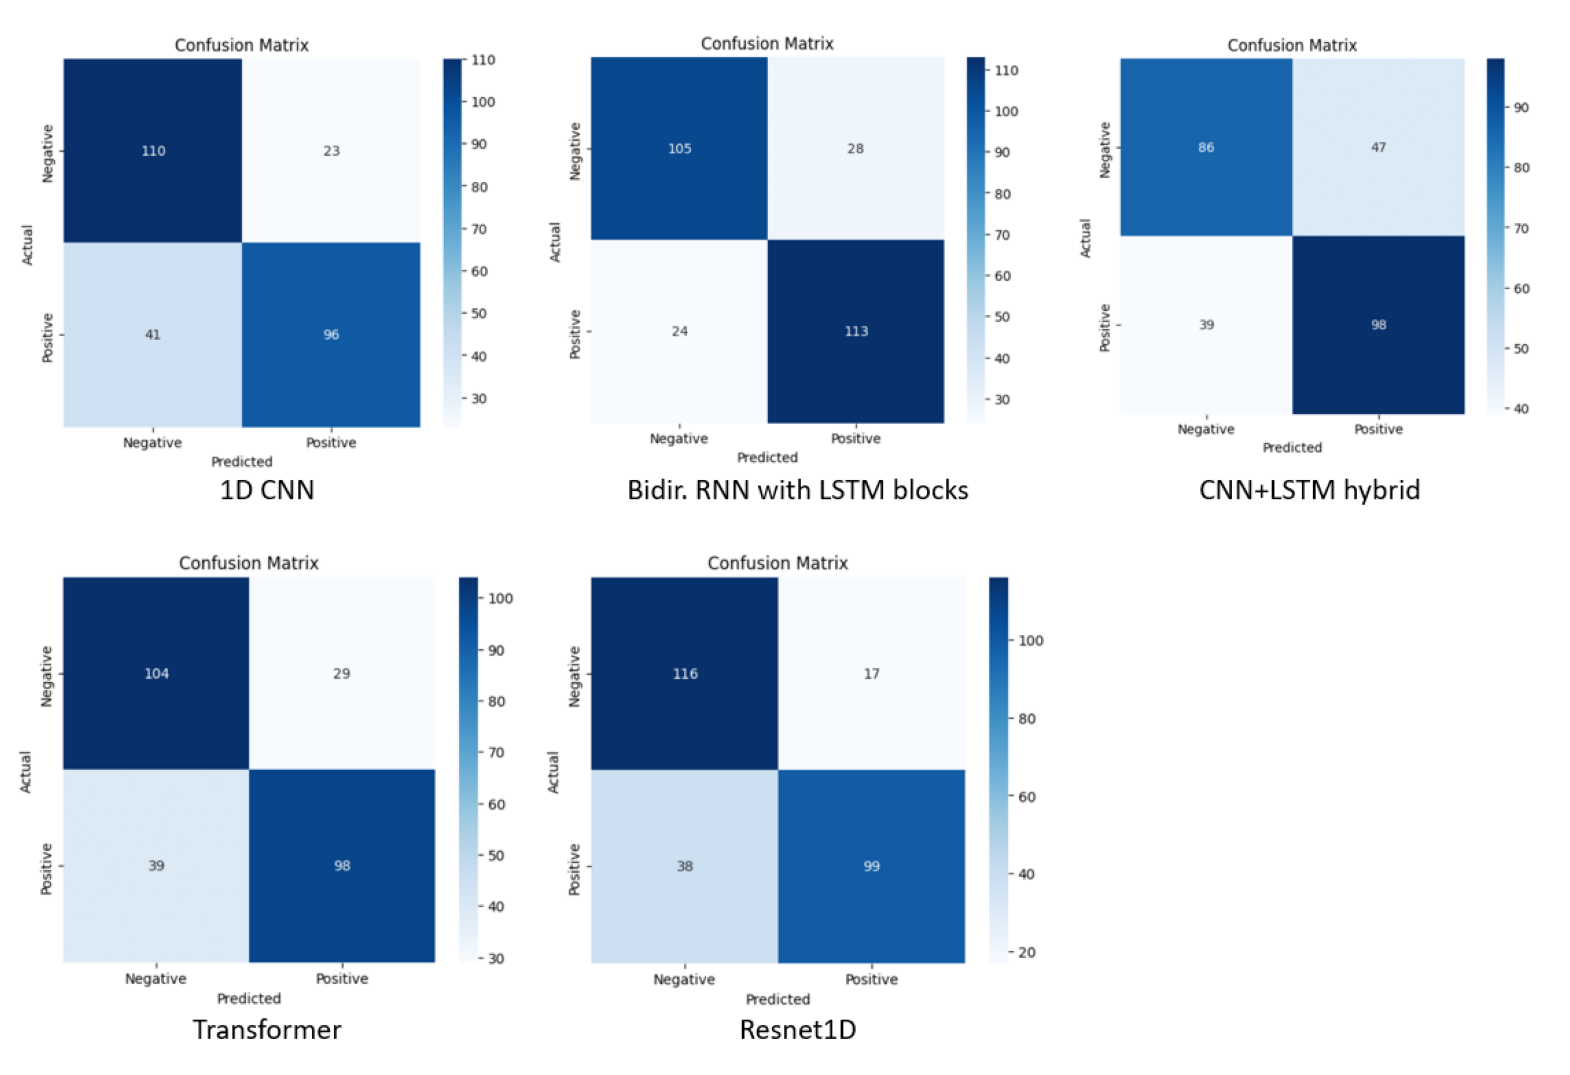

In [83]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

## TASK 3 (BOTH FISTS VS BOTH FEET MOTOR IMAGERY) RESULTS ON 30 SUBJECTS

In [86]:
img=plt.imread("./results/task3/r3.png")

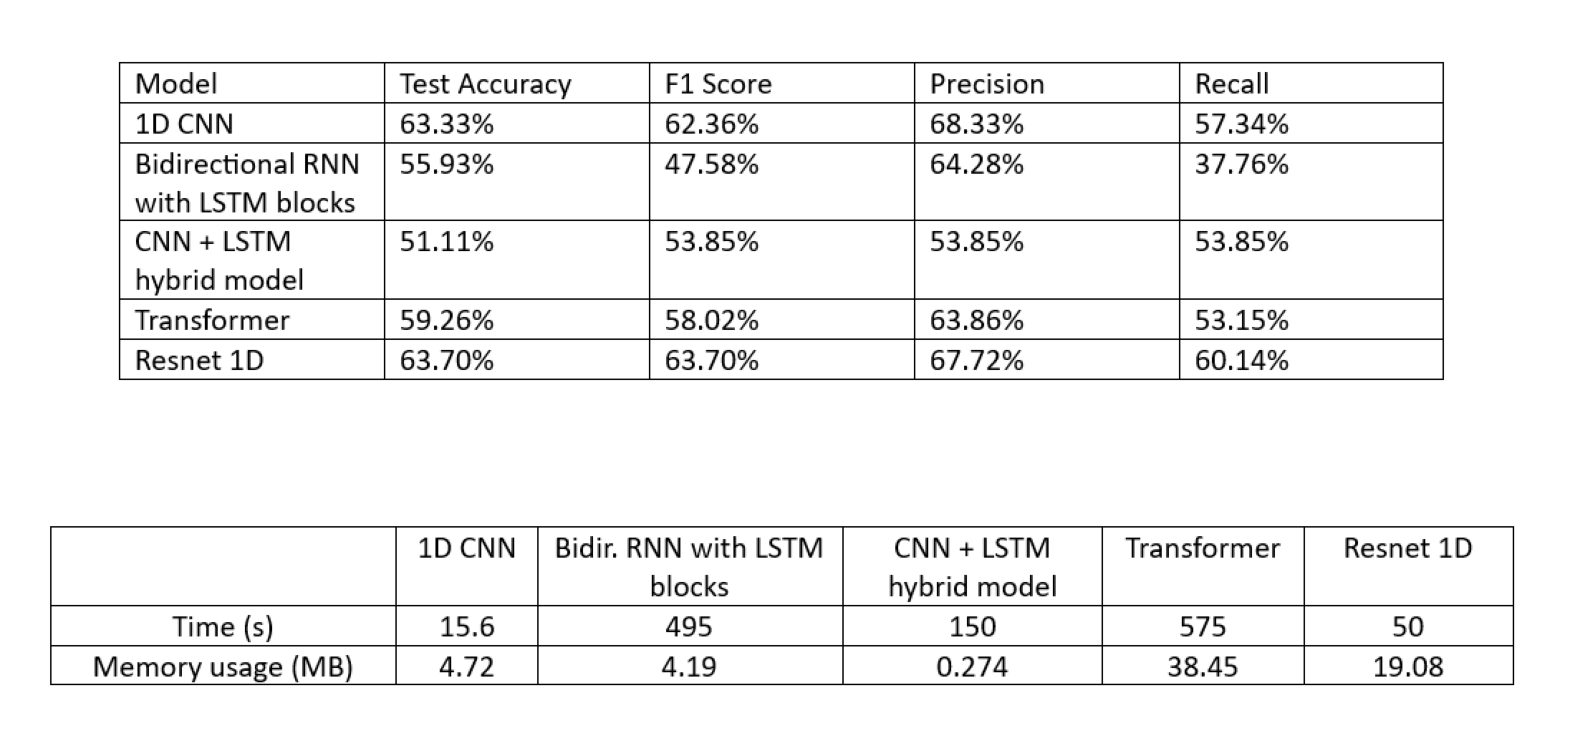

In [87]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

In [88]:
img=plt.imread("./results/task3/t3.png")

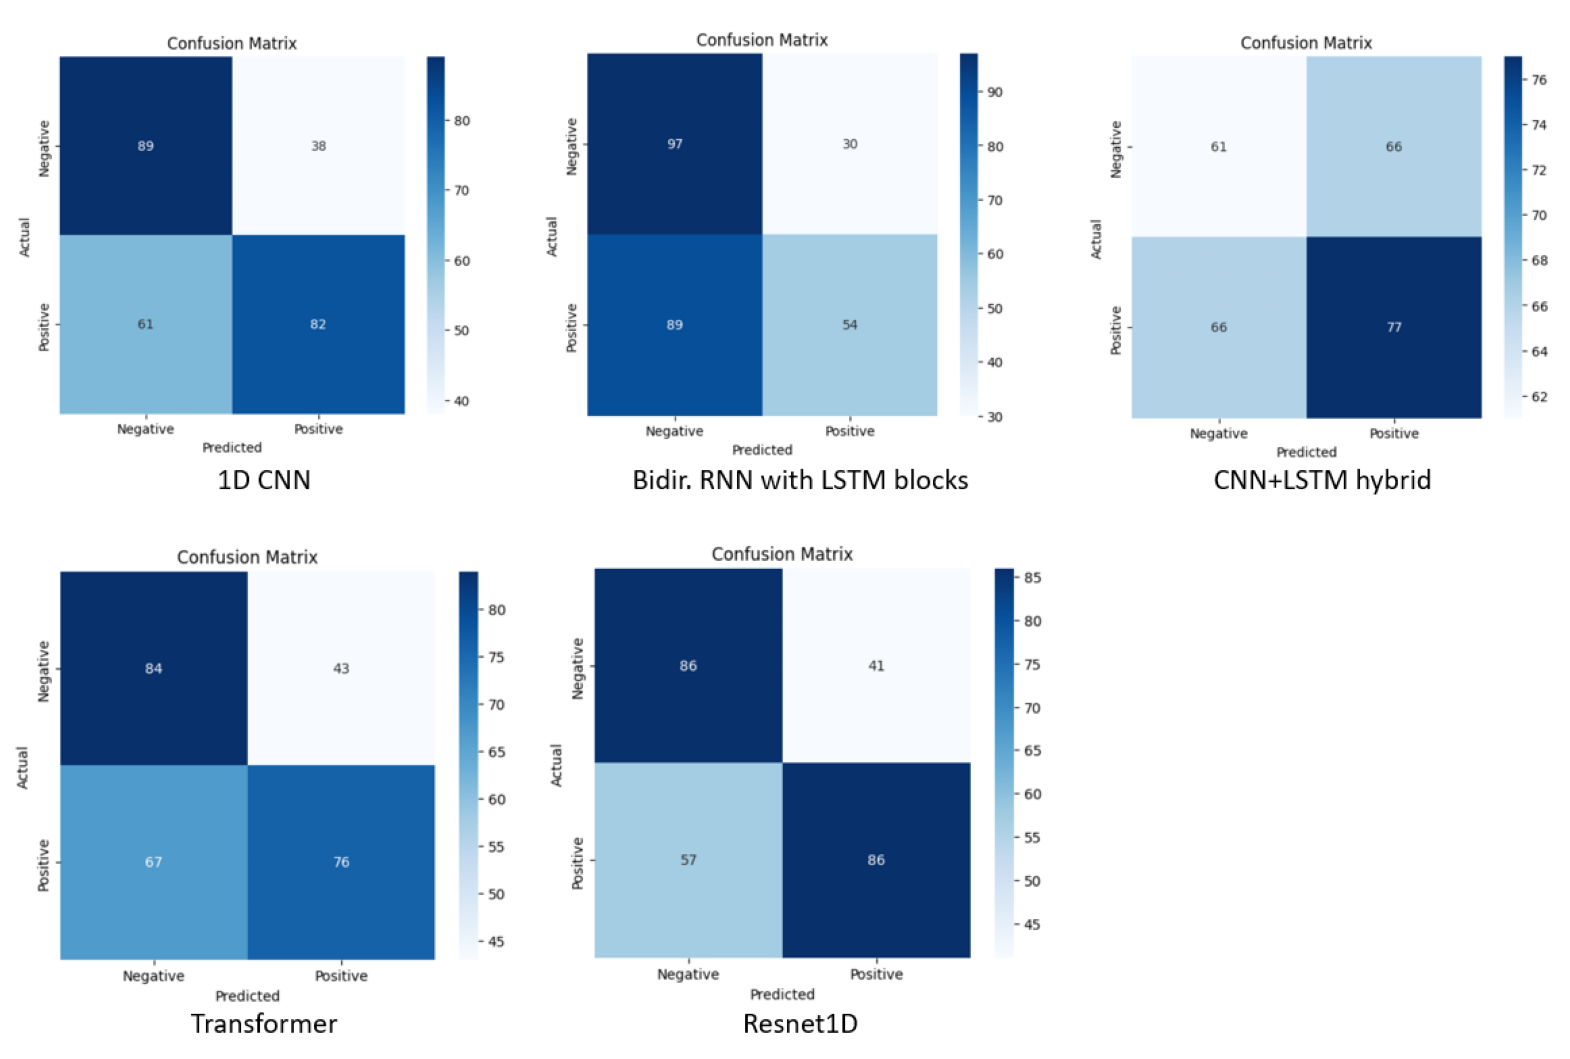

In [89]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

## TASK 4 (BOTH FISTS VS BOTH FEET MOTOR EXECUTION) RESULTS ON 30 SUBJECTS

In [91]:
img=plt.imread("./results/task4/r4.png")

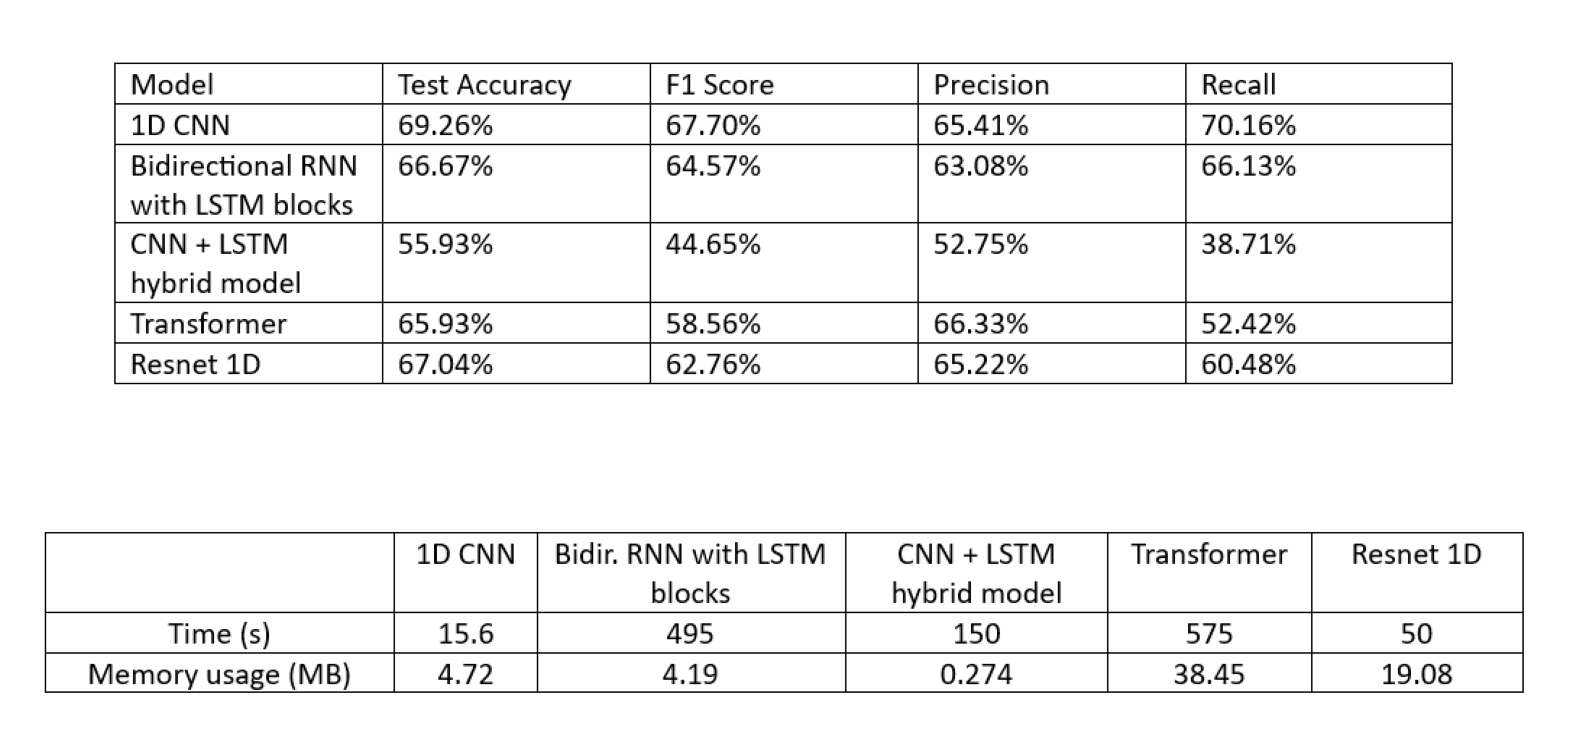

In [92]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

In [93]:
img=plt.imread("./results/task4/t4.png")

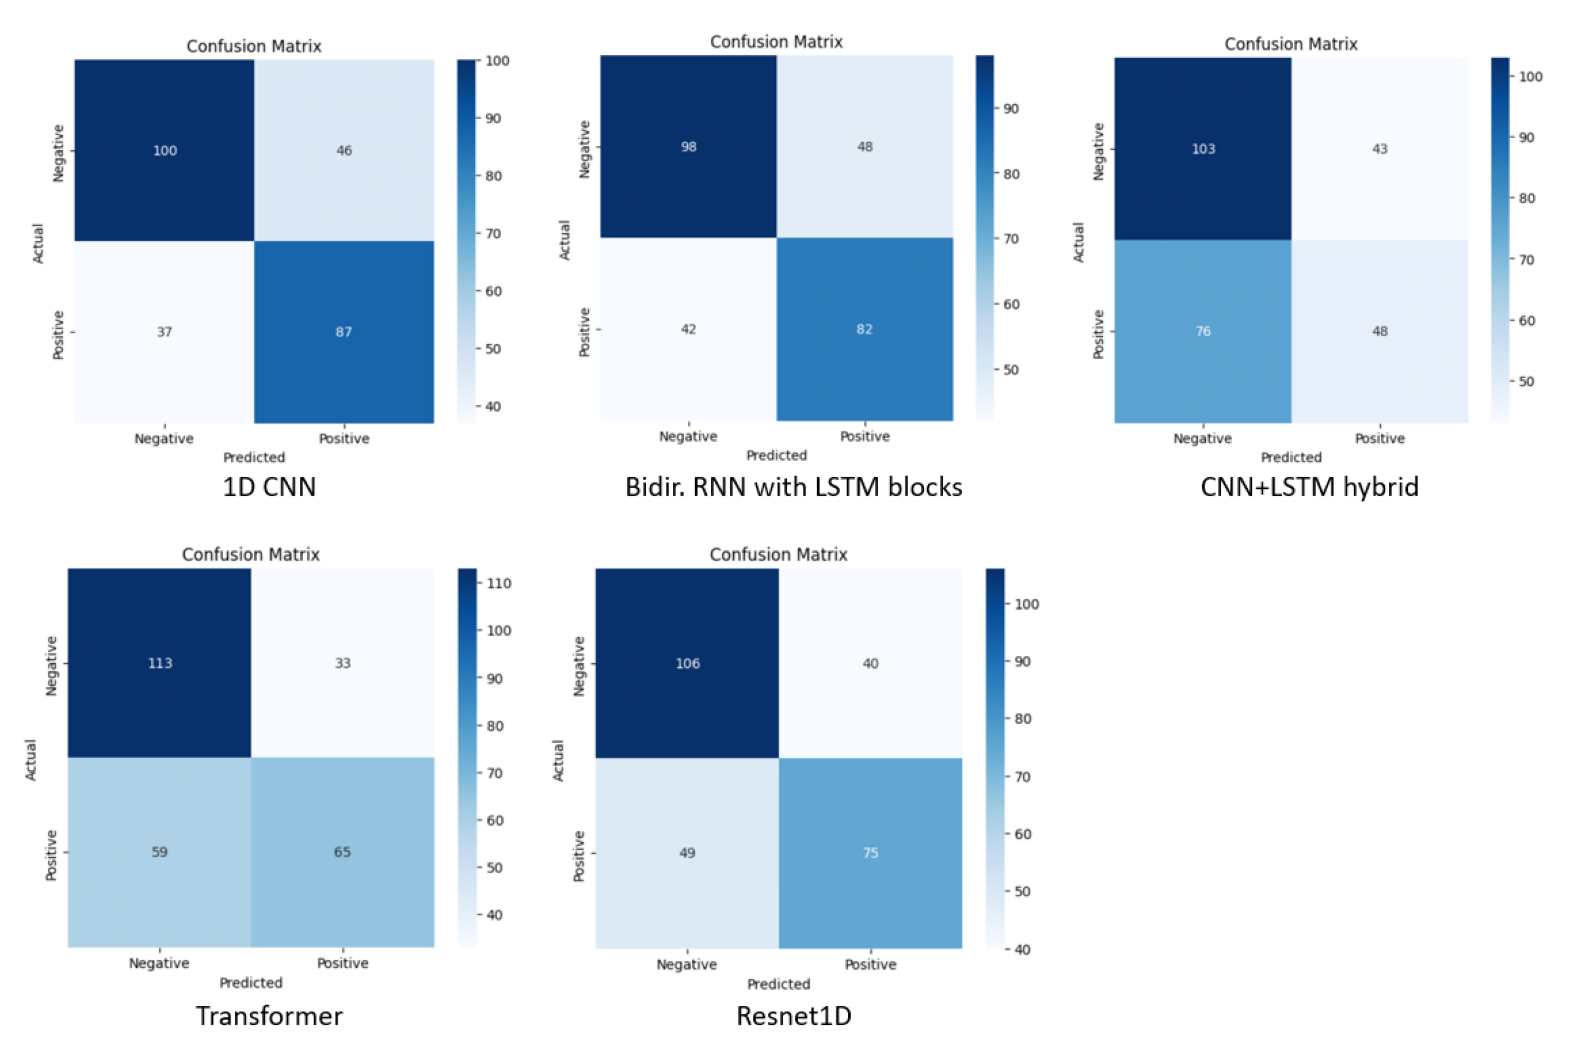

In [94]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

## interpretation of group level analysis results
### Inferences from Results on 30 Subjects:

---

### Task 1: Left vs Right Hand Motor Imagery Classification  
- **Best Performing Model**: **CNN + LSTM Hybrid**  
  - **Reason**: The hybrid model maintains high accuracy and F1 score, indicating its robustness in capturing spatial-temporal patterns across multiple subjects.
  - **Limitation**: High memory usage and computational cost due to increased complexity from combining CNN and LSTM layers.

- **Other Models**:
  - **1D CNN**: Shows good performance but slightly lower than CNN + LSTM, highlighting its limitation in temporal pattern recognition.
  - **BiLSTM**: Performs moderately due to temporal sequence modeling but lacks spatial analysis.
  - **Transformer**: Moderate performance; long-range dependency modeling is less effective for spatial features.
  - **ResNet 1D**: Underperforms as residual connections may not capture nuanced EEG patterns effectively.

- **Comparison with Single Subject Results**:
  - Accuracy is slightly reduced due to increased inter-subject variability.
  - CNN + LSTM remains the most consistent across subjects, proving its generalizability.

---

### Task 2: Left vs Right Hand Motor Execution Classification  
- **Best Performing Model**: **1D CNN**  
  - **Reason**: Highest accuracy and F1 score, confirming its ability to capture localized spatial patterns effectively.
  - **Limitation**: Inability to model long-term dependencies as effectively as LSTM-based models.

- **Other Models**:
  - **CNN + LSTM Hybrid**: Slightly lower performance due to potential overfitting with increased subject variability.
  - **BiLSTM**: Performs moderately due to temporal pattern recognition but lacks spatial extraction.
  - **Transformer**: Shows moderate performance, likely due to insufficient local spatial feature extraction.
  - **ResNet 1D**: Performs the lowest, consistent with single-subject results.

- **Comparison with Single Subject Results**:
  - Performance is slightly lower due to inter-subject differences.
  - 1D CNN's robustness is maintained, indicating good generalizability for motor execution tasks.

---

### Task 3: Both Fists vs Both Feet Motor Imagery Classification  
- **Best Performing Model**: **CNN + LSTM Hybrid**  
  - **Reason**: Effective in learning complex spatial-temporal dependencies needed for motor imagery tasks across multiple subjects.
  - **Limitation**: High computational and memory cost, with longer training time.

- **Other Models**:
  - **1D CNN**: Good performance but less effective in capturing temporal patterns.
  - **BiLSTM**: Moderate performance due to effective temporal pattern recognition but lacks spatial feature extraction.
  - **Transformer**: Performs moderately, limited by spatial pattern recognition.
  - **ResNet 1D**: Lowest performance due to inadequate temporal learning capabilities.

- **Comparison with Single Subject Results**:
  - Accuracy decreases more noticeably compared to Task 1, indicating higher inter-subject variability in motor imagery for fists vs feet.
  - CNN + LSTM's generalization capability is validated across subjects.

---

### Task 4: Both Fists vs Both Feet Motor Execution Classification  
- **Best Performing Model**: **1D CNN**  
  - **Reason**: Consistently captures localized spatial features that characterize motor execution tasks.
  - **Limitation**: Cannot effectively capture long-term temporal dependencies.

- **Other Models**:
  - **CNN + LSTM Hybrid**: Slightly lower performance, likely due to overfitting and inter-subject variability.
  - **BiLSTM**: Moderate performance due to temporal modeling but lacks spatial analysis.
  - **Transformer**: Moderate performance, limited by local spatial pattern recognition.
  - **ResNet 1D**: Consistently underperforms.

- **Comparison with Single Subject Results**:
  - Accuracy and F1 scores are slightly lower, reflecting increased inter-subject variability.
  - 1D CNN's robustness is maintained, showing consistent spatial pattern learning.

---

### General Observations and Comparison:
1. **Inter-Subject Variability**:
   - Performance generally decreases for all models compared to single-subject results due to increased variability in EEG signals among subjects.
   - CNN + LSTM Hybrid shows the most resilience to variability in motor imagery tasks.
   - 1D CNN demonstrates the most consistent performance for motor execution tasks.

2. **Motor Imagery vs Motor Execution**:
   - **Motor Imagery** (Tasks 1 and 3): CNN + LSTM Hybrid is consistently the best due to its superior spatial-temporal learning.
   - **Motor Execution** (Tasks 2 and 4): 1D CNN performs best, highlighting the dominance of localized spatial patterns in execution tasks.

3. **Model Limitations**:
   - **1D CNN**: Limited temporal pattern recognition.
   - **BiLSTM**: Ineffective spatial feature extraction.
   - **Transformer**: Struggles with localized spatial features.
   - **ResNet 1D**: Residual connections do not contribute significantly to learning temporal dependencies.
   - **CNN + LSTM Hybrid**: High computational cost and memory usage, with potential overfitting.

4. **Generalization and Robustness**:
   - **CNN + LSTM Hybrid** and **1D CNN** show the best generalization across subjects.
   - Overall performance drops with increased subject count, highlighting the challenge of inter-subject variability in EEG-based classification.

---

### Conclusion:
- **Motor Imagery Tasks**: **CNN + LSTM Hybrid** is recommended for its robust temporal and spatial feature learning.
- **Motor Execution Tasks**: **1D CNN** is preferred for its effective spatial pattern recognition and computational efficiency.
- The results highlight the importance of balancing model complexity and generalization capability for multi-subject EEG classification.